
# AA Flight Delay EDA & Labeling

This notebook:
- Loads `AA_FLIGHT_RECORD_FINAL_HUBS.csv`
- Computes delays and labels:
  - `dep_delay = DEP_TIME - CRS_DEP_TIME`
  - `arr_delay = ARR_TIME - CRS_ARR_TIME`
  - `delta_delay = arr_delay - dep_delay`
  - `delay_change_flag = 1 if |delta_delay| > threshold else 0`
- Cleans cancellations/diversions and trims extreme outliers
- Produces summary statistics and EDA plots
- Saves a labeled CSV for downstream modeling


# Import Packages

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
# === Config ===
CSV_PATH = "../data/raw/flight_data/AA_FLIGHT_RECORD_FINAL_HUBS.csv"
OUTPUT_DIR = "../data/processed"
PLOTS_SUBDIR = "plots"
LABELED_CSV_NAME = "aa_flights_labeled.csv"

DELTA_THRESHOLD_MIN = 10   # minutes for classification label |delta_delay|
MAX_ABS_DELAY_MIN = 600    # outlier cutoff in minutes (10 hours)
SAMPLE_SCATTER = 20000     # max points shown in scatter plot


In [11]:
try:
    import seaborn as sns
    sns.set_style("whitegrid")
except Exception:
    pass

pd.options.display.max_columns = 120
print("pandas version:", pd.__version__)

pandas version: 2.2.3


Helper Functions for fixing day-rollover problem

In [25]:
def hhmm_to_minutes(val):
    """Convert HHMM (e.g., 730) or HMM (e.g., 55) to minutes since midnight."""
    if pd.isna(val):
        return np.nan
    try:
        iv = int(val)
        h = iv // 100
        m = iv % 100
        if 0 <= h <= 48 and 0 <= m < 60:  # loose guard
            return h * 60 + m
    except Exception:
        pass
    return np.nan


def time_diff_minutes(actual_min, sched_min):
    """Compute (actual - scheduled) minutes with simple day-rollover heuristics."""
    if np.isnan(actual_min) or np.isnan(sched_min):
        return np.nan
    diff = actual_min - sched_min
    # Handle potential midnight crossovers:
    if diff < -720:   # >12h early -> assume actual is next day
        diff += 1440
    elif diff > 720:  # >12h late  -> assume scheduled is next day
        diff -= 1440
    return diff


def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

In [26]:
# === Load CSV ===
ensure_dir(OUTPUT_DIR)
plots_dir = os.path.join(OUTPUT_DIR, PLOTS_SUBDIR)
ensure_dir(plots_dir)

df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]
print("Rows:", len(df))
df.head()

Rows: 224328


,FL_DATE,MKT_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,WHEELS_OFF,CRS_ARR_TIME,ARR_TIME,WHEELS_ON,CANCELLED,DIVERTED,YEAR,MONTH,AIRCRAFT_TYPE,DESCRIPTION
0,2023-01-01,AA,1,JFK,LAX,730,726.0,743.0,1052,1054.0,1042.0,0,0,2023,1,699,Airbus Industrie A321/Lr
1,2023-01-02,AA,1,JFK,LAX,730,723.0,742.0,1052,1037.0,1031.0,0,0,2023,1,699,Airbus Industrie A321/Lr
2,2023-01-03,AA,1,JFK,LAX,730,807.0,829.0,1052,1140.0,1128.0,0,0,2023,1,699,Airbus Industrie A321/Lr
3,2023-01-04,AA,1,JFK,LAX,730,727.0,747.0,1052,1039.0,1024.0,0,0,2023,1,699,Airbus Industrie A321/Lr
4,2023-01-05,AA,1,JFK,LAX,730,725.0,746.0,1052,1046.0,1032.0,0,0,2023,1,699,Airbus Industrie A321/Lr


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224328 entries, 0 to 224327
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   FL_DATE             224328 non-null  object 
 1   MKT_UNIQUE_CARRIER  224328 non-null  object 
 2   OP_CARRIER_FL_NUM   224328 non-null  int64  
 3   ORIGIN              224328 non-null  object 
 4   DEST                224328 non-null  object 
 5   CRS_DEP_TIME        224328 non-null  int64  
 6   DEP_TIME            222040 non-null  float64
 7   WHEELS_OFF          221873 non-null  float64
 8   CRS_ARR_TIME        224328 non-null  int64  
 9   ARR_TIME            221815 non-null  float64
 10  WHEELS_ON           221815 non-null  float64
 11  CANCELLED           224328 non-null  int64  
 12  DIVERTED            224328 non-null  int64  
 13  YEAR                224328 non-null  int64  
 14  MONTH               224328 non-null  int64  
 15  AIRCRAFT_TYPE       224328 non-nul

# The proportions of cancelled/diverted flights

Total flights: 224328
Cancelled flights: 1.10%, Cancelled: 2458
Diverted flights: 0.30%, Diverted: 675
Normal flights:   98.60%, Normal: 221195


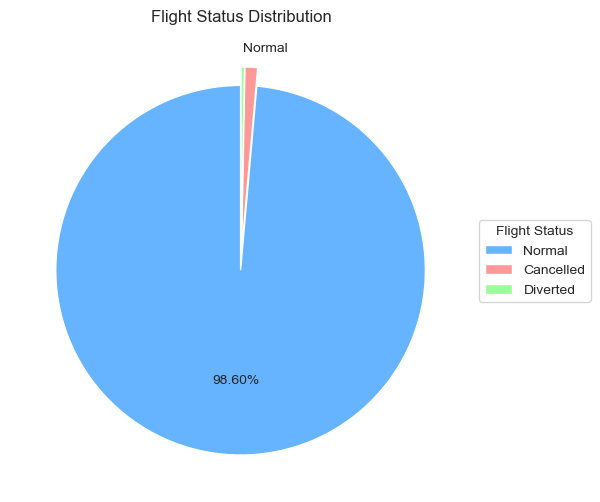

In [27]:
# === Compute proportions ===
total = len(df)
cancel_count = df["CANCELLED"].sum()
divert_count = df["DIVERTED"].sum()
normal_count = total - cancel_count - divert_count

cancel_rate = cancel_count / total * 100
divert_rate = divert_count / total * 100
normal_rate = normal_count / total * 100

print(f"Total flights: {total}")
print(f"Cancelled flights: {cancel_rate:.2f}%, Cancelled: {cancel_count}")
print(f"Diverted flights: {divert_rate:.2f}%, Diverted: {divert_count}")
print(f"Normal flights:   {normal_rate:.2f}%, Normal: {normal_count}")

# === Pie chart ===
labels = ["Normal", "Cancelled", "Diverted"]
sizes = [normal_count, cancel_count, divert_count]
colors = ["#66b3ff", "#ff9999", "#99ff99"]

fig, ax = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax.pie(
    sizes, 
    labels=["", "", "Normal"],
    autopct=lambda pct: f"{pct:.2f}%" if pct > 5 else "",
    startangle=90, 
    colors=colors,
    explode=(0.05, 0.05, 0.05)
)

ax.legend(wedges, labels, title="Flight Status", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title("Flight Status Distribution")
plt.show()

In [28]:
# === Convert HHMM-like times to minutes since midnight ===
for col in ["CRS_DEP_TIME", "DEP_TIME", "CRS_ARR_TIME", "ARR_TIME"]:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")
    df[col + "_MIN"] = df[col].apply(hhmm_to_minutes)

df.head()

,FL_DATE,MKT_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,WHEELS_OFF,CRS_ARR_TIME,ARR_TIME,WHEELS_ON,CANCELLED,DIVERTED,YEAR,MONTH,AIRCRAFT_TYPE,DESCRIPTION,CRS_DEP_TIME_MIN,DEP_TIME_MIN,CRS_ARR_TIME_MIN,ARR_TIME_MIN
0,2023-01-01,AA,1,JFK,LAX,730,726.0,743.0,1052,1054.0,1042.0,0,0,2023,1,699,Airbus Industrie A321/Lr,450,446.0,652,654.0
1,2023-01-02,AA,1,JFK,LAX,730,723.0,742.0,1052,1037.0,1031.0,0,0,2023,1,699,Airbus Industrie A321/Lr,450,443.0,652,637.0
2,2023-01-03,AA,1,JFK,LAX,730,807.0,829.0,1052,1140.0,1128.0,0,0,2023,1,699,Airbus Industrie A321/Lr,450,487.0,652,700.0
3,2023-01-04,AA,1,JFK,LAX,730,727.0,747.0,1052,1039.0,1024.0,0,0,2023,1,699,Airbus Industrie A321/Lr,450,447.0,652,639.0
4,2023-01-05,AA,1,JFK,LAX,730,725.0,746.0,1052,1046.0,1032.0,0,0,2023,1,699,Airbus Industrie A321/Lr,450,445.0,652,646.0


In [37]:
df[(df['DEP_TIME'] <= 2400) & (df['DEP_TIME'] >= 2350)]

,FL_DATE,MKT_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,WHEELS_OFF,CRS_ARR_TIME,ARR_TIME,WHEELS_ON,CANCELLED,DIVERTED,YEAR,MONTH,AIRCRAFT_TYPE,DESCRIPTION,CRS_DEP_TIME_MIN,DEP_TIME_MIN,CRS_ARR_TIME_MIN,ARR_TIME_MIN,dep_delay,arr_delay,delta_delay,delay_change_flag
145,2023-01-30,AA,10,LAX,JFK,2215,2400.0,22.0,633,800.0,752.0,0,0,2023,1,699,Airbus Industrie A321/Lr,1335,1440.0,393,480.0,105.0,87.0,-18.0,1
147,2023-01-08,AA,28,LAX,JFK,2359,2352.0,11.0,820,818.0,808.0,0,0,2023,1,699,Airbus Industrie A321/Lr,1439,1432.0,500,498.0,-7.0,-2.0,5.0,0
315,2023-01-07,AA,238,LAX,JFK,2359,2352.0,9.0,820,810.0,803.0,0,0,2023,1,699,Airbus Industrie A321/Lr,1439,1432.0,500,490.0,-7.0,-10.0,-3.0,0
918,2023-01-07,AA,340,LAX,MIA,2350,2357.0,20.0,747,808.0,802.0,0,0,2023,1,637,Boeing 777-300/300ER/333ER,1430,1437.0,467,488.0,7.0,21.0,14.0,1
925,2023-01-14,AA,340,LAX,MIA,2350,2352.0,13.0,740,740.0,733.0,0,0,2023,1,637,Boeing 777-300/300ER/333ER,1430,1432.0,460,460.0,2.0,0.0,-2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217472,2024-02-25,AA,395,PHX,PHL,2355,2352.0,5.0,607,549.0,543.0,0,0,2024,2,699,Airbus Industrie A321/Lr,1435,1432.0,367,349.0,-3.0,-18.0,-15.0,1
217474,2024-02-27,AA,395,PHX,PHL,2355,2351.0,10.0,607,545.0,542.0,0,0,2024,2,699,Airbus Industrie A321/Lr,1435,1431.0,367,345.0,-4.0,-22.0,-18.0,1
217476,2024-02-29,AA,395,PHX,PHL,2355,2358.0,22.0,607,622.0,617.0,0,0,2024,2,699,Airbus Industrie A321/Lr,1435,1438.0,367,382.0,3.0,15.0,12.0,1
218823,2024-02-28,AA,1563,DCA,LGA,2245,2359.0,10.0,2354,57.0,50.0,0,0,2024,2,698,Airbus Industrie A319,1365,1439.0,1434,57.0,74.0,63.0,-11.0,1


In [29]:
# === Compute delays ===
df["dep_delay"]   = [time_diff_minutes(a, s) for a, s in zip(df["DEP_TIME_MIN"], df["CRS_DEP_TIME_MIN"])]
df["arr_delay"]   = [time_diff_minutes(a, s) for a, s in zip(df["ARR_TIME_MIN"], df["CRS_ARR_TIME_MIN"])]
df["delta_delay"] = df["arr_delay"] - df["dep_delay"]

# Remove canceled/diverted flights
df = df[(df["CANCELLED"] == 0) & (df["DIVERTED"] == 0)].copy()

# === Drop rows missing core values ===
df = df.dropna(subset=["dep_delay", "arr_delay", "delta_delay"]).copy()

# === Trim extreme outliers ===
mask = (
    df["dep_delay"].abs() <= MAX_ABS_DELAY_MIN
) & (
    df["arr_delay"].abs() <= MAX_ABS_DELAY_MIN
) & (
    df["delta_delay"].abs() <= MAX_ABS_DELAY_MIN * 2
)
removed = (~mask).sum()
df = df[mask].copy()

print(f"Rows after cleaning: {len(df):,} (removed {removed:,} outliers)")

# === Classification label ===
df["delay_change_flag"] = (df["delta_delay"].abs() > DELTA_THRESHOLD_MIN).astype(int)

df[["dep_delay","arr_delay","delta_delay","delay_change_flag"]].head()

Rows after cleaning: 220,818 (removed 377 outliers)


,dep_delay,arr_delay,delta_delay,delay_change_flag
0,-4.0,2.0,6.0,0
1,-7.0,-15.0,-8.0,0
2,37.0,48.0,11.0,1
3,-3.0,-13.0,-10.0,0
4,-5.0,-6.0,-1.0,0


In [30]:
# === Summary statistics ===
display(df[["dep_delay","arr_delay","delta_delay"]].describe().round(2))

print("Class balance (delay_change_flag):")
display(df["delay_change_flag"].value_counts(normalize=True).rename("share").round(3))

,dep_delay,arr_delay,delta_delay
count,220818.00,220818.00,220818.00
mean,12.84,5.77,-7.07
std,48.30,51.57,16.48
min,-598.00,-600.00,-85.00
25%,-5.00,-17.00,-17.00
50%,-2.00,-6.00,-9.00
75%,9.00,11.00,0.00
max,600.00,600.00,202.00


Class balance (delay_change_flag):


delay_change_flag
1    0.55
0    0.45
Name: share, dtype: float64

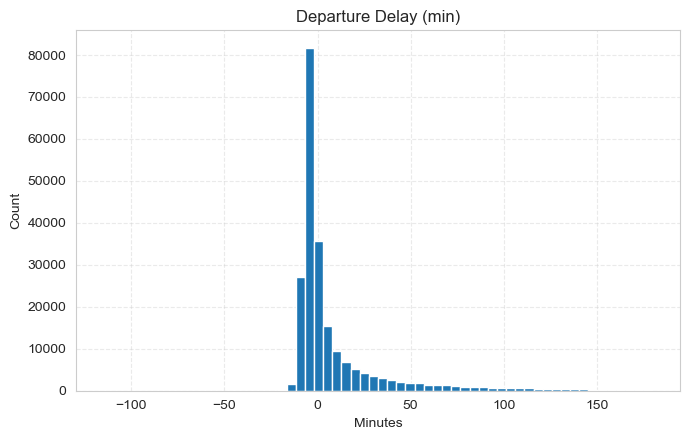

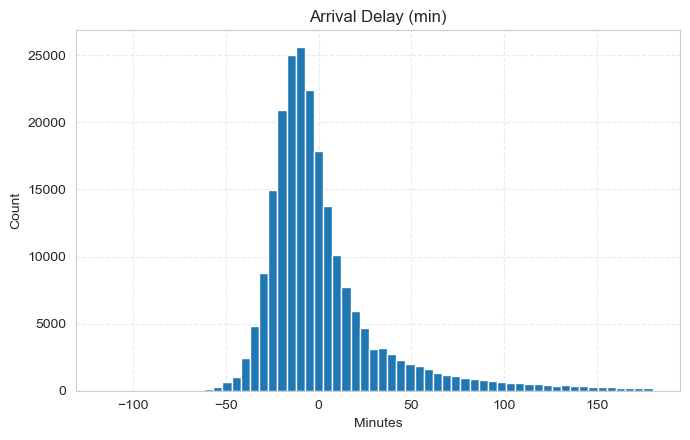

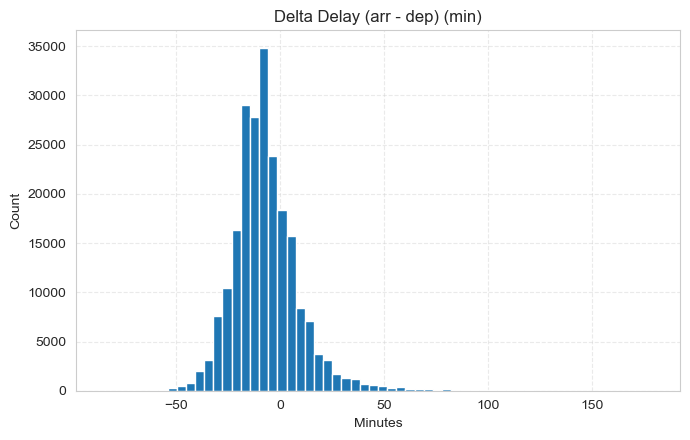

In [31]:
# === Histograms ===
def hist_plot(series, title, fname, bins=60, xmin=-120, xmax=180):
    s = series.dropna()
    s = s[(s >= xmin) & (s <= xmax)]
    plt.figure(figsize=(7, 4.5))
    plt.hist(s.values, bins=bins)
    plt.title(title)
    plt.xlabel("Minutes")
    plt.ylabel("Count")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, fname), dpi=150)
    plt.show()

hist_plot(df["dep_delay"],   "Departure Delay (min)",                "hist_dep_delay.png")
hist_plot(df["arr_delay"],   "Arrival Delay (min)",                  "hist_arr_delay.png")
hist_plot(df["delta_delay"], "Delta Delay (arr - dep) (min)",        "hist_delta_delay.png")

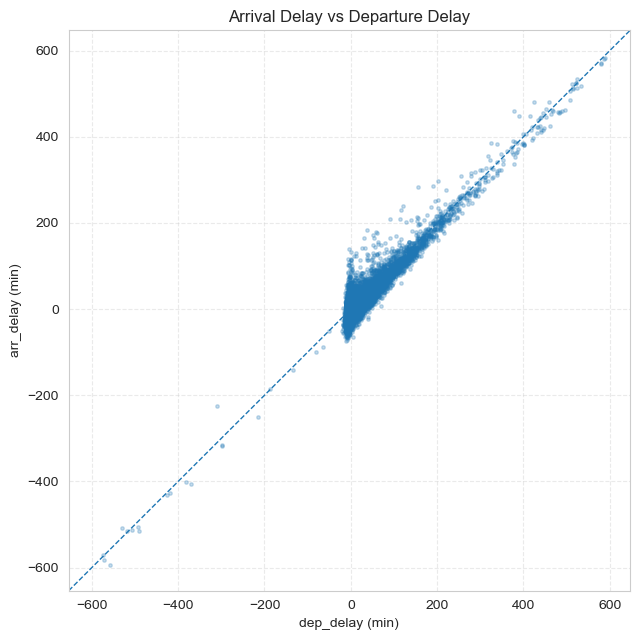

In [32]:
# === Scatter: dep_delay vs arr_delay ===
sample = df.sample(min(SAMPLE_SCATTER, len(df)), random_state=42)
plt.figure(figsize=(6.5, 6.5))
plt.scatter(sample["dep_delay"], sample["arr_delay"], s=6, alpha=0.25)
# Reference line y=x
lims = [
    min(plt.xlim()[0], plt.ylim()[0]),
    max(plt.xlim()[1], plt.ylim()[1]),
]
plt.plot(lims, lims, linestyle="--", linewidth=1)
plt.xlim(lims)
plt.ylim(lims)
plt.title("Arrival Delay vs Departure Delay")
plt.xlabel("dep_delay (min)")
plt.ylabel("arr_delay (min)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "scatter_arr_vs_dep.png"), dpi=150)
plt.show()

In [33]:
# === Destination-level summary (if DEST exists) ===
if "DEST" in df.columns:
    dest_summary = (
        df.groupby("DEST")
          .agg(
              n_flights=("delta_delay", "size"),
              delta_mean=("delta_delay", "mean"),
              pct_makeup=("delta_delay", lambda x: (x < 0).mean() * 100.0),
          )
          .sort_values("n_flights", ascending=False)
    )
    display(dest_summary.head(20))
    dest_summary.to_csv(os.path.join(OUTPUT_DIR, "airport_dest_summary.csv"))
    print("Saved →", os.path.join(OUTPUT_DIR, "airport_dest_summary.csv"))
else:
    print("Column 'DEST' not found; skipping destination summary.")

,n_flights,delta_mean,pct_makeup
DEST,,,
DFW,33673,-8.032073,74.347400
MIA,27615,-6.132645,71.533587
CLT,27402,-6.750967,74.195314
ORD,26263,-8.894795,77.009481
LAX,22627,-7.713484,71.419101
PHX,19259,-7.316683,72.319435
DCA,17696,-6.014919,72.400542
PHL,16892,-6.498283,73.620649
LGA,16675,-5.226627,73.499250


Saved → ../data/processed/airport_dest_summary.csv


In [34]:
# === Save labeled dataset ===
save_cols = [
    "FL_DATE" if "FL_DATE" in df.columns else None,
    "YEAR" if "YEAR" in df.columns else None,
    "MONTH" if "MONTH" in df.columns else None,
    "MKT_UNIQUE_CARRIER" if "MKT_UNIQUE_CARRIER" in df.columns else None,
    "OP_CARRIER_FL_NUM" if "OP_CARRIER_FL_NUM" in df.columns else None,
    "AIRCRAFT_TYPE" if "AIRCRAFT_TYPE" in df.columns else None,
    "DESCRIPTION" if "DESCRIPTION" in df.columns else None,
    "ORIGIN" if "ORIGIN" in df.columns else None,
    "DEST" if "DEST" in df.columns else None,
    "CRS_DEP_TIME", "DEP_TIME", "CRS_ARR_TIME", "ARR_TIME",
    "dep_delay", "arr_delay", "delta_delay", "delay_change_flag",
]
save_cols = [c for c in save_cols if c is not None and c in df.columns]
labeled_path = os.path.join(OUTPUT_DIR, LABELED_CSV_NAME)
df.to_csv(labeled_path, index=False, columns=save_cols)
print(f"Saved labeled dataset -> {labeled_path} ({len(df):,} rows)")

Saved labeled dataset -> ../data/processed/aa_flights_labeled.csv (220,818 rows)



---
### Next steps
- Join **METAR** weather snapshots (nearest-prior obs at ORIGIN/DEST) as additional features.
- Add route/airport priors (historical OTP by OD pair and hour-of-day).
- Train:
  - Classification: `abs(delta_delay) > DELTA_THRESHOLD_MIN`
  - Regression: `delta_delay` (predict magnitude and sign)
- Evaluate cost-sensitive metrics aligned with operations (e.g., false-hold vs missed-hold costs).
